In [16]:
from google.colab import drive
drive.mount('/content/gdrive')
input_dir = '/content/gdrive/MyDrive/STAT8056/ml-100k/'
output_dir = '/content/gdrive/MyDrive/STAT8056/MF_model/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.lines import Line2D

from itertools import zip_longest
import copy

import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Load Data

In [18]:
# Load the u.user file into a dataframe
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(os.path.join(input_dir, 'u.user'), 
                    sep='|', 
                    names=u_cols,
                    encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)
users.head(5)

Number of users: 943


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [19]:
# Load the u.items file into a dataframe
i_cols = ['movie id', 'movie title' ,
          'release date','video release date', 'IMDb URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 
          'Children\'s', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
          'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join(input_dir, 'u.item'), 
                     sep='|', 
                     names=i_cols,
                     encoding='latin-1')

n_movies = movies.shape[0]
print("Number of movies:",n_movies)

# Remove 'release date', 'video release date' and 'IMDb URL'
movies.drop(movies.columns[[2, 3, 4]], axis = 1, inplace=True)
movies.head(5)

Number of movies: 1682


,movie id,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
# Load the u.data file into a dataframe
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings = pd.read_csv(os.path.join(input_dir, 'u.data'), 
                      sep='\t', 
                      names=r_cols, 
                      encoding='latin-1')
n_ratings = ratings.shape[0]
print('Number of rates:', n_ratings)

# Drop the 'timestamp' column
ratings = ratings.drop('unix_timestamp', axis=1)
ratings.head(5)

Number of rates: 100000


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


# Data Exploration

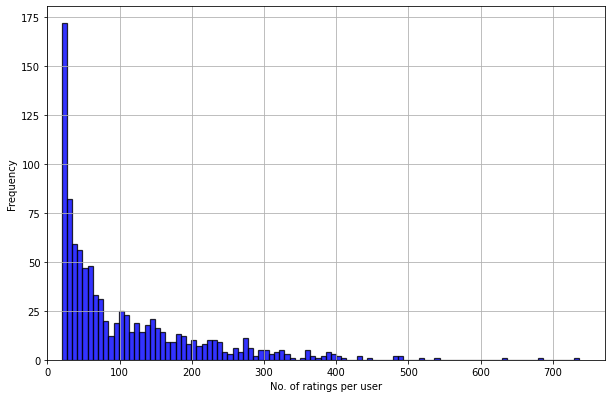

In [22]:
# Histogram of no. of ratings per user
userRatingGroup = ratings.groupby("user_id")['rating'].count()

f, ax = plt.subplots(figsize=(10,6.5))
userRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.8, ax=ax)
ax.set_xlabel('No. of ratings per user')
ax.set_ylabel('Frequency')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

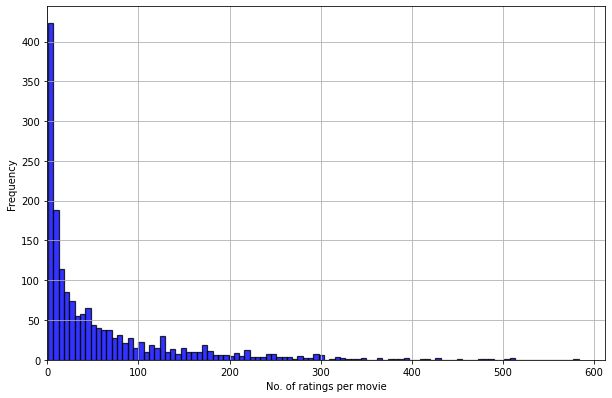

In [23]:
# Histogram of no. of ratings per movie
movieRatingGroup = ratings.groupby("movie_id")['rating'].count()

f, ax = plt.subplots(figsize=(10,6.5))
movieRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                      linewidth=1.25, alpha=0.8, ax=ax)
ax.set_xlabel('No. of ratings per movie')
ax.set_ylabel('Frequency')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

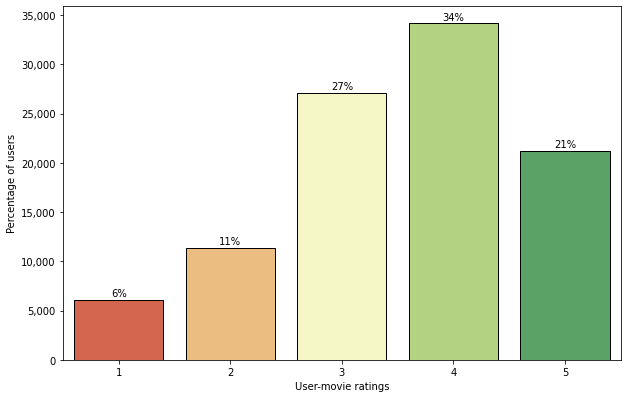

In [24]:
# Rating distribution
movieRatingDistGroup = ratings['rating'].value_counts() \
                                        .sort_index() \
                                        .reset_index() \
                                        #.to_pandas()


fig, ax = plt.subplots(figsize=(10,6.5))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)
ax.set_xlabel("User-movie ratings")
ax.set_ylabel('Percentage of users')
ax.xaxis.set_tick_params()
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

plt.show()

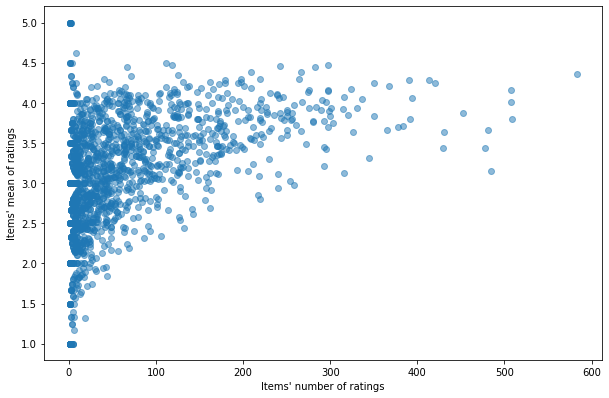

In [25]:
# Scatterplot: Mean of rating v.s. number of rating
movieRatingGroupMean = ratings.groupby("movie_id")['rating'].mean()

fig, ax = plt.subplots(figsize=(10,6.5))
ax.scatter(movieRatingGroup, movieRatingGroupMean, alpha=0.5)
ax.set_xlabel("Items' number of ratings")
ax.set_ylabel("Items' mean of ratings")
plt.show()

# Keras Matrix Factorization NN

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras 
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Embedding
from keras.layers.merge import dot

from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

In [27]:
# 5-fold cross validtion
k = 1
ratings_base = pd.read_csv(os.path.join(input_dir, f'u{k}.base'), 
                           sep='\t', 
                           names=r_cols, 
                           encoding='latin-1')
ratings_test = pd.read_csv(os.path.join(input_dir, f'u{k}.test'), 
                           sep='\t', 
                           names=r_cols, 
                           encoding='latin-1')

ratings_base = ratings_base.drop('unix_timestamp', axis=1)
ratings_test = ratings_test.drop('unix_timestamp', axis=1)

print('Number of rates in base set:', ratings_base.shape[0])
print('Number of rates in test set:', ratings_test.shape[0])
ratings_test.head(5)

Number of rates in base set: 80000
Number of rates in test set: 20000


,user_id,movie_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


In [28]:
# # Saved for Group-Spesific Method in Matlab
# np.savetxt(os.path.join(input_dir, f'u{k}_base.txt'), 
#            ratings_base.values, 
#            fmt=['%s', '%s', '%s'], 
#            delimiter=':')
# np.savetxt(os.path.join(input_dir, f'u{k}_test.txt'), 
#            ratings_test.values, 
#            fmt=['%s', '%s', '%s'], delimiter=':')

In [29]:
# Randomly split the base set to 80% for training and 20% for validation
split = np.random.rand(len(ratings_base)) < 0.8
train = ratings_base[split]
valid = ratings_base[~split]
print(train.shape , valid.shape)

(63924, 3) (16076, 3)


## Matrix Factorization with NN

### Build the model

In [31]:
# Hyperparameters
n_latent_factors=50
dense_l2 = 1e-4 * 6
min_rating = 1
max_rating = 5
user_dropout_rate = 0.4
movie_dropout_rate = 0.4
fc_layer = 96
fc_dropout_rate = 0.4
min_rating=1
max_rating=5

# define RMSE as the evaluation metric
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# User embedding with dropout
user_input = Input(shape = (1,), 
                   name = 'user_input',
                   dtype = 'int64')
user_vec = Embedding(n_users, 
                     n_latent_factors, 
                     name = 'user_embedding')(user_input)
user_vec = Flatten(name = 'FlattenUsers')(user_vec)
user_vec = Dropout(user_dropout_rate, 
                   name = 'user_dropout')(user_vec)

# Movie embedding with dropout
movie_input = Input(shape = (1,), 
                    name = 'movie_input',
                    dtype = 'int64')
movie_vec = Embedding(n_movies, 
                      n_latent_factors,
                      name = 'movie_embedding')(movie_input)
movie_vec = Flatten(name = 'FlattenMovies')(movie_vec)
movie_vec = Dropout(movie_dropout_rate, 
                    name = 'movie_dropout')(movie_vec)
        
# User-Movie score
sim = dot([user_vec, movie_vec], 
          name = 'Simalarity-Dot-Product',axes = 1)

# Add a fully-connected hidden layer with relu activation and dropout
nn_inp = Dense(fc_layer, 
               activation = 'relu', 
               name = 'fc_layer')(sim)
nn_inp = Dropout(fc_dropout_rate, 
                 name = 'fc_dropout')(nn_inp)

# Use sigmoid and liner transforms to rescale into range [0.5, 5.5]
nn_out = Dense(1, activation = 'sigmoid', 
               name = 'output_layer',
               kernel_regularizer = regularizers.l2(dense_l2))(nn_inp)
nn_out = nn_out * (max_rating - min_rating + 1) + min_rating - 0.5

# model building
nn_model = keras.models.Model([user_input, movie_input], nn_out)
nn_model.summary()

# model compile with Adam optimizer and MSE loss
nn_model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='mse', 
                 metrics=[rmse])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        47150       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        84100       ['movie_input[0][0]']            
                                                                                            

In [32]:
# model training
batch_size=128
epochs=50
History = nn_model.fit(x = [train.user_id,train.movie_id],
                       y = train.rating, 
                       batch_size = batch_size,
                       epochs = epochs, 
                       validation_data = ([valid.user_id,valid.movie_id],valid.rating),
                       verbose = 1)

Epoch 1/50
500/500 [==============================] - 9s 11ms/step - loss: 1.2664 - rmse: 1.1230 - val_loss: 1.2550 - val_rmse: 1.1124
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 1.2238 - rmse: 1.1039 - val_loss: 1.1483 - val_rmse: 1.0638
Epoch 3/50
500/500 [==============================] - 5s 10ms/step - loss: 0.9819 - rmse: 0.9880 - val_loss: 1.0196 - val_rmse: 1.0026
Epoch 4/50
500/500 [==============================] - 5s 9ms/step - loss: 0.8456 - rmse: 0.9163 - val_loss: 0.9752 - val_rmse: 0.9803
Epoch 5/50
500/500 [==============================] - 4s 7ms/step - loss: 0.7731 - rmse: 0.8763 - val_loss: 0.9558 - val_rmse: 0.9700
Epoch 6/50
500/500 [==============================] - 5s 9ms/step - loss: 0.7328 - rmse: 0.8529 - val_loss: 0.9440 - val_rmse: 0.9642
Epoch 7/50
500/500 [==============================] - 5s 10ms/step - loss: 0.7066 - rmse: 0.8375 - val_loss: 0.9389 - val_rmse: 0.9618
Epoch 8/50
500/500 [==============================] - 4s 8m

In [33]:
# # Save the trained model and training history
# nn_model.save(os.path.join(output_dir, f'model_k={k}'))

# np.save(os.path.join(output_dir, f'history_k={k}.npy'), 
#         History.history)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/STAT8056/MF_model/model_k=1/assets


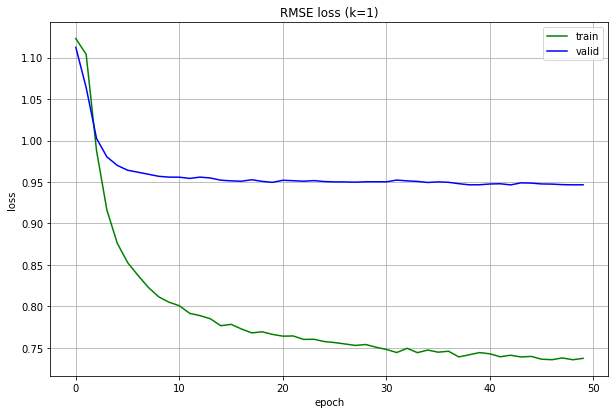

In [34]:
# plot the RMSE curves for trian and valid sets
plt.subplots(figsize=(10,6.5))
plt.plot(History.history['rmse'] , 'g')
plt.plot(History.history['val_rmse'] , 'b')
plt.title(f'RMSE loss (k={k})')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.grid(True)
plt.show()

In [38]:
# Prediction ratings on test set
test = ratings_test
test_pred = nn_model.predict(x = [test.user_id, test.movie_id], 
                             batch_size = 1)
test['pred'] = pd.DataFrame([float(x) for x in test_pred], columns=['pred'])
test_rmse = mean_squared_error(test.rating, test.pred, squared=False) # RMSE
print("test_rmse = " + str(test_rmse))

test_rmse = 0.9783258687069027


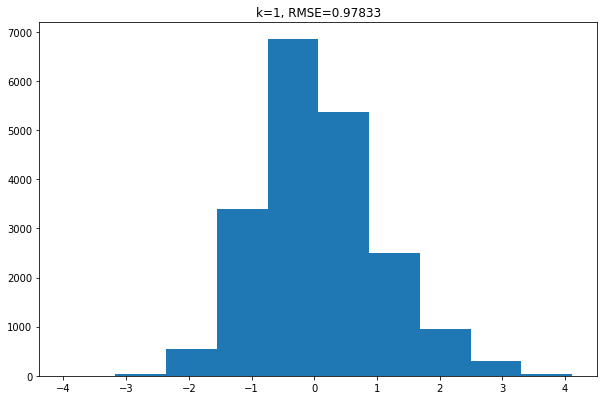

In [39]:
# Plot: Histogram of prediction error
plt.subplots(figsize=(10, 6.5))
plt.hist(test['pred'] - test['rating'])
plt.title(f'k={k}, RMSE={test_rmse:.5f}')
plt.show()

In [40]:
# Save the predictions
# np.save(os.path.join(output_dir, f'predict_k={k}.npy'), 
#         test['pred'])